In [4]:
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from decoder import GreedyDecoder

from data.data_loader import SpectrogramDataset, AudioDataLoader
from model import DeepSpeech

'''
'models/deepspeech_final.pth'
'data/test_manifest.csv'
'''
class params():
    def __init__(self, model_path, test_manifest, cuda=True, verbose=False,
                 batch_size=20, num_workers=4, decoder='greedy',):
        self.model_path = model_path
        self.cuda = cuda
        self.test_manifest = test_manifest
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.decoder = decoder
        self.verbose = verbose

args = params(model_path='models/gru_bi_50.pth', test_manifest='pinyin_val_manifest.csv', cuda=False)

if True:
    model = DeepSpeech.load_model(args.model_path, cuda=args.cuda)
    model.eval()

    labels = DeepSpeech.get_labels(model).lower()
    audio_conf = DeepSpeech.get_audio_conf(model)

    if args.decoder == "beam":
        from decoder import BeamCTCDecoder

        decoder = BeamCTCDecoder(labels, lm_path=args.lm_path, alpha=args.alpha, beta=args.beta,
                                 cutoff_top_n=args.cutoff_top_n, cutoff_prob=args.cutoff_prob,
                                 beam_width=args.beam_width, num_processes=args.lm_workers)
    elif args.decoder == "greedy":
        decoder = GreedyDecoder(labels, blank_index=labels.index('_'))
    else:
        decoder = None
    target_decoder = GreedyDecoder(labels, blank_index=labels.index('_'))
    test_dataset = SpectrogramDataset(audio_conf=audio_conf, manifest_filepath=args.test_manifest, labels=labels,
                                      normalize=True)
    test_loader = AudioDataLoader(test_dataset, batch_size=args.batch_size,
                                  num_workers=args.num_workers)
    total_cer, total_wer, num_tokens, num_chars = 0, 0, 0, 0
    output_data = []
    wers = []
    cers = []
    references = []
    output_transcripts = []
    input_data = []
    for i, (data) in tqdm(enumerate(test_loader), total=len(test_loader)):
        inputs, targets, input_percentages, target_sizes = data
        input_data.append(inputs)
        inputs = Variable(inputs, volatile=True)

        # unflatten targets
        split_targets = []
        offset = 0
        for size in target_sizes:
            split_targets.append(targets[offset:offset + size])
            offset += size

        if args.cuda:
            inputs = inputs.cuda()

        out = model(inputs)  # NxTxH
        seq_length = out.size(1)
        sizes = input_percentages.mul_(int(seq_length)).int()

        # add output to data array, and continue
        output_data.append((out.data.cpu().numpy(), sizes.numpy()))

        decoded_output, offsets, = decoder.decode(out.data, sizes)
        target_strings = target_decoder.convert_to_strings(split_targets)
        for x in range(len(target_strings)):
            transcript, reference = decoded_output[x][0], target_strings[x][0]
            references.append(reference)
            output_transcripts.append(transcript)
            wer_inst = decoder.wer(transcript, reference)
            cer_inst = decoder.cer(transcript, reference)
            total_wer += wer_inst
            total_cer += cer_inst
            num_tokens += len(reference.split())
            num_chars += len(reference)
            if args.verbose:
                print("Ref:", reference.lower())
                print("Hyp:", transcript.lower())
                print("WER:", float(wer_inst) / len(reference.split()), "CER:", float(cer_inst) / len(reference), "\n")
            wers.append(float(wer_inst) / len(reference.split()))
            cers.append(float(cer_inst) / len(reference))
    wer = float(total_wer) / num_tokens
    cer = float(total_cer) / num_chars

    print('Test Summary \t'
          'Average WER {wer:.3f}\t'
          'Average CER {cer:.3f}\t'.format(wer=wer * 100, cer=cer * 100))


100%|██████████| 125/125 [26:43<00:00, 12.83s/it]

Test Summary 	Average WER 22.858	Average CER 6.420	


In [5]:
def parse_transcript(transcript_path):
    with open(transcript_path, 'r', encoding='utf8') as transcript_file:
        transcript = transcript_file.read().replace('\n', '').strip()
    return transcript

with open('pinyin_train_manifest.csv') as f:
    ids = f.readlines()
ids_trans = [x.strip().split(',')[-1] for x in ids]
size = len(ids_trans)
words_dict_train = {}
for ids_tran in ids_trans:
    reference = parse_transcript(ids_tran)
    reference = reference.split(' ')
    for word in reference:
        try:
            words_dict_train[word] += 1
        except:
            words_dict_train[word] = 1

KeyboardInterrupt: 

In [ ]:

with open('words_dict_train.json', 'w') as f:
    json.dump(words_dict_train, f)

In [8]:
import json
with open('words_dict_train.json', 'r') as f:
    words_dict_train = json.load(f)

In [9]:
offsets_index = []
for i in offsets:
    ind = []
    for j in i:
        ind.append(j.numpy()-1)
    offsets_index.append(ind)

In [10]:
len(offsets)
len(decoded_output)

15

In [11]:
import re
py_refer = []
tone_refer = []
py_outputs = []
tone_outputs = []

drop_num = lambda line: re.sub(r"[1-5]", "", line)
drop_py = lambda line: re.sub(r"[a-zA-Z]", "", line).strip()
for reference in references:
    py_refer.append(drop_num(reference))
    tone_refer.append(drop_py(reference))
for output in output_transcripts:
    py_outputs.append(drop_num(output))
    tone_outputs.append(drop_py(output))

In [12]:
num_instance = len(references)
wers_py = np.zeros((num_instance,))
cers_py = np.zeros((num_instance,))
wers_tone = np.zeros((num_instance,))
cers_tone = np.zeros((num_instance,))
for i in range(num_instance):
    wers_py[i] = float(decoder.wer(py_outputs[i], py_refer[i]))/len(py_refer[i].split())
    cers_py[i] = float(decoder.cer(py_outputs[i], py_refer[i]))/len(py_refer[i])
    wers_tone[i] = float(decoder.wer(tone_outputs[i], tone_refer[i]))/len(py_refer[i].split())
    cers_tone[i] = float(decoder.cer(tone_outputs[i], tone_refer[i]))/len(py_refer[i])

In [13]:
#tone_acc = {'1': (0,0), '2': (0,0), ''}
'''
tone_freq = np.zeros((5,))
tone_cor = np.zeros((5,))
for k in range(len(py_refer)):
    py_ref = py_refer[k].split(' ')
    tone_ref = tone_refer[k].split(' ')
    py_op = py_outputs[k].split(' ')
    tone_op = tone_outputs[k].split(' ')
    for i in range(len(py_ref)):
        for j in [0,1,-1,2,-2,3,-3]:
            l = i+j
            if l > -1 and l < len(tone_op):
                if py_ref[i] == py_op[l]:
                    tone_freq[int(tone_ref[i])-1] += 1
                    if tone_ref[i] == tone_op[l]:
                        tone_cor[int(tone_ref[i])-1] += 1
                        break
'''

tone_freq = np.zeros((5,))
tone_cor = np.zeros((5,))
for k in range(len(references)):
    refer = references[k].split(' ')
    output = output_transcripts[k].split(' ')
    for i in range(len(refer)):
        for j in [0,1,-1,2,-2]:
            py_ref = drop_num(refer[i])
            tone_ref = drop_py(refer[i])
            l = i+j
            if l > -1 and l < len(output):
                py_op = drop_num(output[l])
                tone_op = drop_py(output[l])
                if py_ref == py_op:
                    tone_freq[int(tone_ref)-1] += 1
                    if tone_ref == tone_op:
                        tone_cor[int(tone_ref)-1] += 1
                        break

In [14]:
print(tone_freq)
print(tone_cor)
print(tone_cor/tone_freq)

[ 14747.  17349.  12146.  22305.   3499.]
[ 13517.  15654.  10457.  20614.   2822.]
[ 0.91659321  0.90229984  0.86094187  0.9241874   0.80651615]


In [15]:
print('wers:')
print(np.mean(wers_py))
print(np.mean(wers))
print(np.mean(wers_tone))

print('cers')
print(np.mean(cers_py))
print(np.mean(cers))
print(np.mean(cers_tone))

print(wers_py[:10])
print(wers[:10])
print(wers_tone[:10])

print(cers_py[:10])
print(cers[:10])
print(cers_tone[:10])

wers:
0.147370570649
0.229129848135
0.114784570754
cers
0.0511879453564
0.0644182441342
0.028519750866
[ 0.52631579  0.31818182  0.          0.15789474  0.10526316  0.45454545
  0.33333333  0.04545455  0.14814815  0.2173913 ]
[0.5789473684210527, 0.45454545454545453, 0.2631578947368421, 0.42105263157894735, 0.21052631578947367, 0.7272727272727273, 0.4074074074074074, 0.045454545454545456, 0.2222222222222222, 0.30434782608695654]
[ 0.36842105  0.22727273  0.26315789  0.31578947  0.10526316  0.31818182
  0.18518519  0.          0.07407407  0.08695652]
[ 0.19736842  0.125       0.          0.05263158  0.05263158  0.19354839
  0.15533981  0.02150538  0.03883495  0.05050505]
[0.25263157894736843, 0.1440677966101695, 0.05263157894736842, 0.10526315789473684, 0.06315789473684211, 0.21739130434782608, 0.16153846153846155, 0.017391304347826087, 0.046153846153846156, 0.05737704918032787]
[ 0.09210526  0.05208333  0.06578947  0.07894737  0.02631579  0.07526882
  0.04854369  0.          0.01941748

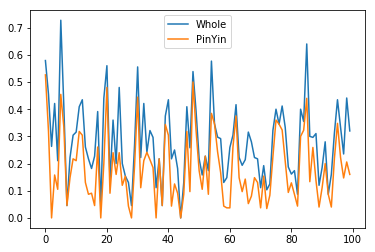

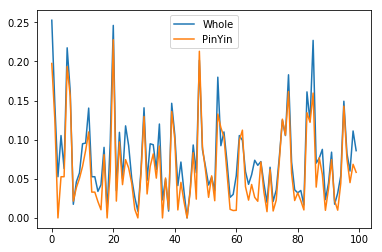

In [16]:
plt.figure()
plt.plot(wers[:100])
plt.plot(wers_py[:100])
#plt.plot(wers_tone[:100])
plt.legend(['Whole','PinYin','tone'])
plt.show()

plt.figure()
plt.plot(cers[:100])
plt.plot(cers_py[:100])
#plt.plot(cers_tone[:100])
plt.legend(['Whole','PinYin','tone'])
plt.show()

In [17]:
print(py_refer[0])
print(py_outputs[0])
print(tone_refer[0])
print(tone_outputs[0])

hao rong yi pan lai yi wei wang wang zhe yi pian huang wu you niu shen er qu
hou wei pan lae yi wei weng wang zhi biaon huang wu youg niu shi er qu
3 2 4 4 2 1 4 4 5 4 2 4 1 2 4 3 1 2 4
3 1 4 5 1 4 4 2 4 3 1 2 4 3 4 2 4


(15, 811, 33)


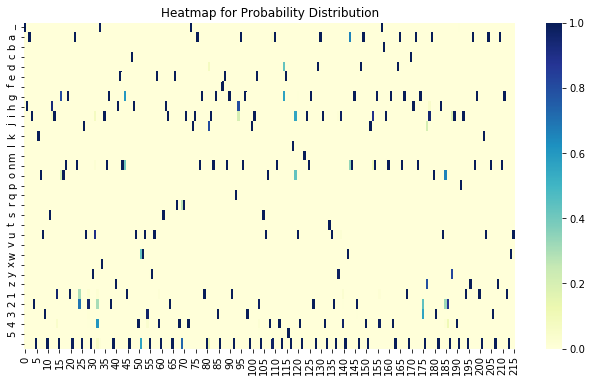

In [20]:
# output data is softmax output
output, size = output_data[-1][0], output_data[-1][1]
#len(offsets)
#len(decoded_output)
print(output.shape)
ind = offsets_index[0]
#print(ind)
yticklabels = list(labels)
plt.figure(figsize=(11,6))
sns.heatmap(output[0][ind].T, cmap="YlGnBu", yticklabels=yticklabels)
plt.title('Heatmap for Probability Distribution')
plt.show()

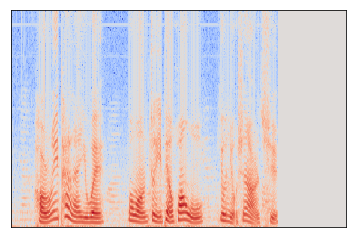

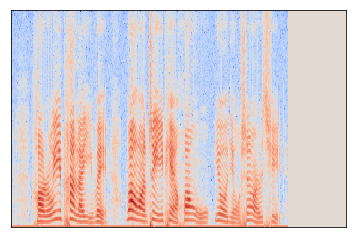

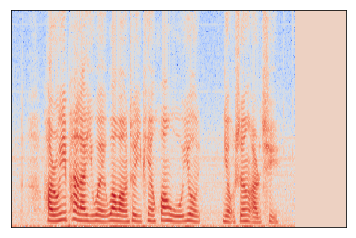

In [13]:
#input_data[0][1].numpy().shape
#niu3, three spetrum, the first one is not accurate (last two are more accurate)
#the first one has lower frequency in general 
def plot_spetrum(i, input_data):
    list_index = int(i/20)
    batch_index = i%20
    spetrum = input_data[list_index][batch_index][0].numpy()
    plt.figure()
    specshow(spetrum)
    plt.show()

from librosa.display import specshow

i = 0
plot_spetrum(i, input_data)
i = 2
plot_spetrum(i, input_data)
i = 3
plot_spetrum(i, input_data)

In [21]:
def analyze_word(word, output_transcripts, references):
    word_target = []
    word_output = []
    num_instance = len(references)
    for i in range(num_instance):
        transcript, reference = output_transcripts[i], references[i]
        word_output.append(word in transcript)
        word_target.append(word in reference)
    word_output = np.array(word_output) #.astype(int)
    word_target = np.array(word_target) #.astype(int)
    return word_target, word_output
word = 'niu3'
word_target, word_output = analyze_word(word, output_transcripts, references)

In [22]:
print(np.where(word_target))
print(np.where(word_output))

(array([   0,    2,    3,    4,   10,   32,   51,   66,  256,  305,  330,
        839,  996, 1172, 1368, 1452, 1875, 2114, 2344, 2391]),)
(array([   0,    2,    3,    4,   10,   51,   66,  256,  305,  839, 1172,
       1368, 1452, 2114, 2344]),)


In [23]:
i = 0
print(references[i])
print(output_transcripts[i])
print(wers[i], cers[i])

hao3 rong2 yi4 pan4 lai2 yi1 wei4 wang4 wang5 zhe4 yi2 pian4 huang1 wu2 you4 niu3 shen1 er2 qu4
hou3 wei1 pan4 lae5 yi1 wei4 weng4 wang2 zhi4 biaon3 huang1 wu2 youg4 niu3 shi4 er2 qu4
0.5789473684210527 0.25263157894736843


In [24]:
#recall and precision
tp = word_output*word_target
recall = sum(tp)/sum(word_target)
precision = sum(tp)/sum(word_output)
print(recall)
print(precision)

0.75
1.0


In [25]:
fp = (1 - word_target)*word_output
print(np.where(fp))
i = 496
print(references[i])
print(output_transcripts[i])
print(wers[i], cers[i])

(array([], dtype=int64),)
wang2 yu4 lin2 chuai1 zhe5 qian2 dao4 zhuan1 wa3 chang3 mai3 zhuan1 yi4 qi3 qu4 de5 cun1 gan4 bu5 zhao3 chang2 zhang3 di2 gu5 yi2 zhen4 chang2 zhang3 jue2 ding4 gei3 you1 hui4 jia4
wang2 yu4 lin2 chuai4 zhe5 qian2 dao4 zhuan1 wa2 chang3 bai3 zhuan1 yi4 qi3 qu4 de5 cun1 gan4 bo5 zhao3 chang2 zhang3 di2 gu4 yi5 zhen4 chang2 zhang3 jue2 ding4 gean3 you4 hui4 jia3
0.2647058823529412 0.05555555555555555


In [26]:
fn = word_target*(1-word_output)
print(np.where(fn))
i = 781
print(references[i])
print(output_transcripts[i])
print(wers[i], cers[i])

(array([  32,  330,  996, 1875, 2391]),)
bo2 lin2 ai4 le4 yue4 tuan2 zao3 qi1 gui1 ding4 zhi3 zhao1 shou1 ri4 er3 man4 ren2 ren4 wei2 ri4 er3 man4 ren2 sheng1 xing4 ping2 wen3 wu4 shi2 yi4 yu2 he2 zuo4
bo2 lin2 ai4 yue4 yue4 tuan2 zao3 qi1 gui1 ding4 zhi3 zhao1 shou4 rhi4 er4 man4 ren2 ren4 wei2 re4 e r ban4 ren4 sheng1 xing4 ping2 wen2 wu1 shi2 yi4 yu2 he2 zuo3
0.36363636363636365 0.075


In [27]:
acc_position = np.zeros((5,))
num_instance = len(references)
for i in range(num_instance):
    transcript, reference = output_transcripts[i], references[i]
    transcript = transcript.split(' ')
    reference = reference.split(' ')
    for j in range(5):
        acc_position[j] += transcript[j]==reference[j]
acc_position

array([ 2008.,  1930.,  1884.,  1907.,  1891.])

In [28]:
words_dict = {}
for reference in references:
    reference = reference.strip().split(' ')
    for word in reference:
        try:
            words_dict[word] += 1
        except:
            words_dict[word] = 1

In [29]:
num_words = len(words_dict.keys())
freq = np.zeros((num_words,))
recall = np.zeros((num_words,))
precision = np.zeros((num_words,))
i = 0
for key, value in words_dict.items():
    word_target, word_output = analyze_word(key, output_transcripts, references)
    tp = word_output*word_target
    recall[i] = sum(tp)/sum(word_target)
    precision[i] = sum(tp)/sum(word_output) 
    freq[i] = words_dict_train.get(key, 0)
    i += 1

/home/tx443/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [30]:
for key, value in words_dict.items():
    if value >1500:
        print(key)

de5


In [31]:
len(recall)

940

In [32]:
precision1 = precision[freq<1500]
recall1 = recall[freq<1500]
freq1 = freq[freq<1500]

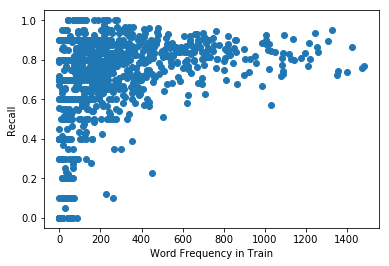

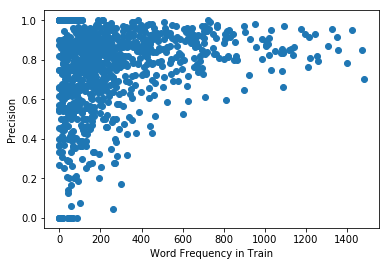

In [33]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(freq1, recall1, 'o')
#plt.title('frequency -- recall')
plt.xlabel('Word Frequency in Train')
plt.ylabel('Recall')
plt.show()

plt.figure()
plt.plot(freq1, precision1, 'o')
#plt.title('frequency -- precision')
plt.xlabel('Word Frequency in Train')
plt.ylabel('Precision')
plt.show()

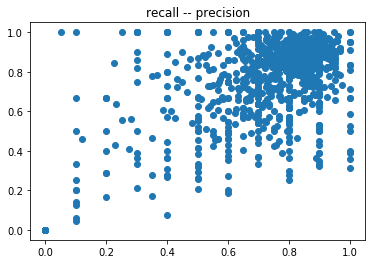

In [34]:
plt.figure()
plt.plot(recall1, precision1, 'o')
plt.title('recall -- precision')
plt.show()

10